## Boot, Boot, Boot For The Home Team

The New York Times Crossword offers a shockingly addicting feature that many of you may very well be familiar with -- the "Daily Mini." This crossword puzzle is the morning sport found in many-an-office, and (at least for me) has often sparked heated competition that, admittedly, sometimes goes a bit too far.


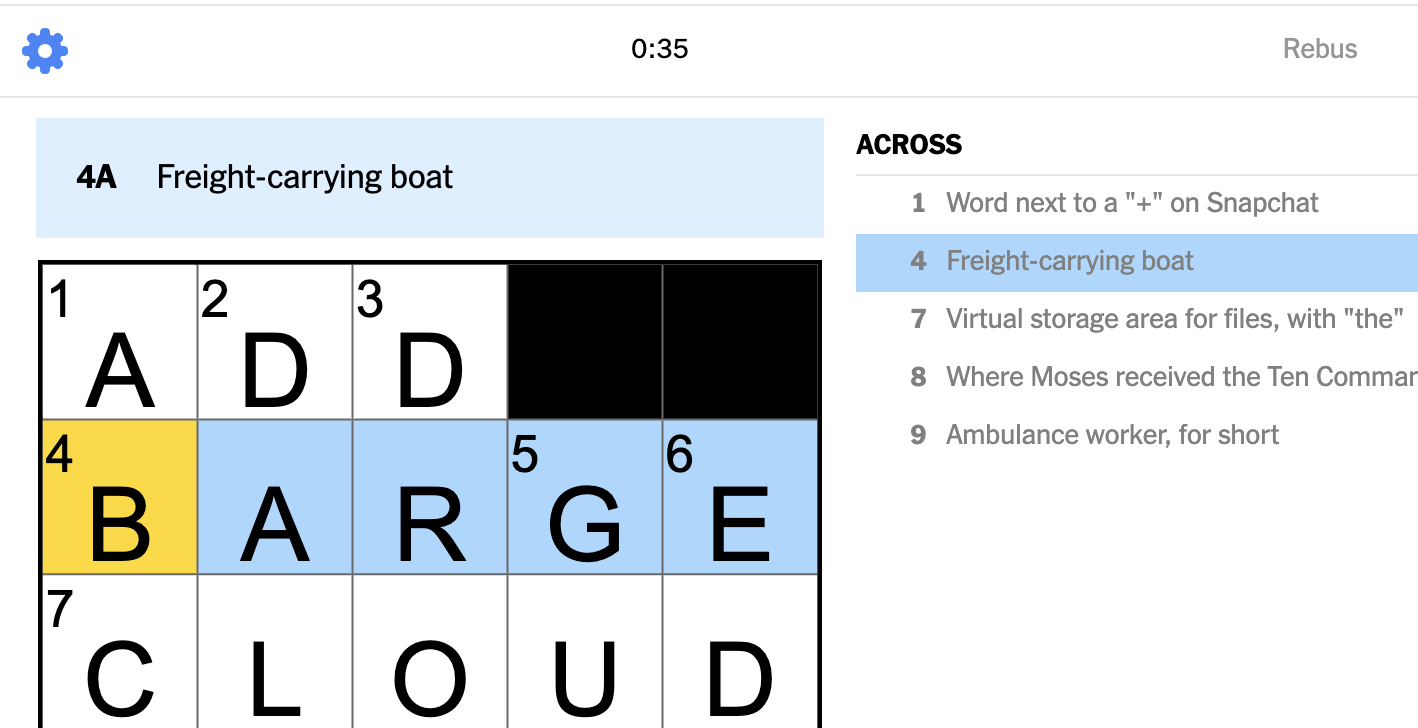

For an experienced puzzler a typical mini usually takes less than 60 seconds, with the exception of the Saturday puzzle which is roughly twice the size of the standard minis. My girlfriend and I have fallen into the habit of saving our times and smugly messaging them to each other when we feel confident our speed can't be beat. Unfortunately this often leads to me sending self-satisfied screenshots that receive prompt replies from her completing the same puzzle seconds faster. Truly I shall never learn. Recently though we've wondered, which of us is truly faster? And by how much?

To quantify this, I wrote a simply python script to scrape the NYT crossword puzzle page and, using her and my login info separately, I was able to pull down a list of an entire year's worth of data points 365 puzzles for each of us). My goal is to analyze the data and clarify the confidence interval arround the bootstrap distribution of our average time difference and proclaim, once and for all, who is faster (_she is_), and by how much (TBD!)

In [195]:
pd.options.display.max_rows = 1000

In [196]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta, date
from statistics import mean
from sklearn.utils import resample

In [197]:
dates = []
start_date = date(2018, 8, 8)
end_date = date(2019, 8, 9)

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

for single_date in daterange(start_date, end_date):
    dates.append(single_date.strftime("%Y/%m/%d"))

dates = pd.DataFrame(dates)
dates = dates.rename(columns={0: "date"})

In [198]:
jane = pd.read_csv('jane2019.csv', error_bad_lines=False, names = ['minute', 'colon', 'tens', 'ones'])
jane = pd.concat([jane, dates], axis = 1)

In [199]:
jane.iloc[100:110]

,minute,colon,tens,ones,date
100,2,:,5,0,2018/11/16
101,1,:,5,2,2018/11/17
102,0,:,2,3,2018/11/18
103,1,4,:,2,2018/11/19
104,1,:,3,3,2018/11/20
105,1,:,5,4,2018/11/21
106,0,:,5,3,2018/11/22
107,0,:,5,4,2018/11/23
108,3,:,0,5,2018/11/24
109,1,:,0,3,2018/11/25


Wow, apparently it took me over 14 minutes to solve the November 19th release. Instead of cleaning that up, I'm going to elect instead to wipe that out and forever purge it from my memory. Do better jane.

In [200]:
jane.shape

(366, 5)

In [201]:
jane = jane.drop([103])
jane.iloc[100:110]


,minute,colon,tens,ones,date
100,2,:,5,0,2018/11/16
101,1,:,5,2,2018/11/17
102,0,:,2,3,2018/11/18
104,1,:,3,3,2018/11/20
105,1,:,5,4,2018/11/21
106,0,:,5,3,2018/11/22
107,0,:,5,4,2018/11/23
108,3,:,0,5,2018/11/24
109,1,:,0,3,2018/11/25
110,0,:,5,3,2018/11/26


In [202]:
j2.dtypes

minute         float64
colon           object
tens           float64
ones           float64
date            object
solve_times    float64
dtype: object

In [203]:
j2.tens = jane.tens.astype(str).astype(int)
j2.dtypes

minute         float64
colon           object
tens           float64
ones           float64
date            object
solve_times    float64
dtype: object

In [204]:
j2['solve_times'] = j2.apply(lambda row: row.minute*60 + row.tens*10+row.ones, axis=1)

In [205]:
j2.head()

,minute,colon,tens,ones,date,solve_times
0,4.0,:,0.0,3.0,2018/08/08,243.0
1,1.0,:,3.0,5.0,2018/08/09,95.0
2,1.0,:,5.0,7.0,2018/08/10,117.0
3,2.0,:,3.0,8.0,2018/08/11,158.0
4,0.0,:,4.0,6.0,2018/08/12,46.0


In [206]:
rose = pd.read_csv('rose2019.csv', error_bad_lines=False, names = ['minute', 'colon', 'tens', 'ones'])
rose = pd.concat([rose, dates], axis = 1)
rose.dtypes
rose['solve_times'] = rose.apply(lambda row: row.minute*60 + row.tens*10+row.ones, axis=1)
rose.head()

,minute,colon,tens,ones,date,solve_times
0,2,:,3,7,2018/08/08,157
1,5,:,2,0,2018/08/09,320
2,0,:,4,4,2018/08/10,44
3,1,:,2,3,2018/08/11,83
4,0,:,4,4,2018/08/12,44


In [207]:
rose.shape

(366, 6)

In [208]:
j2.shape

(366, 6)

In [209]:
merge = pd.merge(j2[['date', 'solve_times']], rose[['date', 'solve_times']], on = 'date')
merge = merge.rename(columns={'solve_times_x': "jet",
                             'solve_times_y': "rwp"})
merge.shape

(366, 3)

In [210]:
merge.iloc[102:106]

,date,jet,rwp
102,2018/11/18,23.0,30
103,2018/11/19,NaN,64
104,2018/11/20,93.0,58
105,2018/11/21,114.0,32


My null value on November 19th will confound our results if I preserve Rose's data on that day. Since puzzles vary in difficulty we want to be careful to compare times _only_ on days where she and I both completed the puzzle.

In [211]:
merge = merge.dropna()
merge.shape

(365, 3)

In [212]:
merge.iloc[102:106]

,date,jet,rwp
102,2018/11/18,23.0,30
104,2018/11/20,93.0,58
105,2018/11/21,114.0,32
106,2018/11/22,53.0,37


In [213]:
time_diffs = pd.melt(merge, id_vars=['date'], 
                value_vars=['rwp', 'jet'],
                var_name = 'identity',
                value_name = 'solve_time'
            )
time_diffs.head()

,date,identity,solve_time
0,2018/08/08,rwp,157.0
1,2018/08/09,rwp,320.0
2,2018/08/10,rwp,44.0
3,2018/08/11,rwp,83.0
4,2018/08/12,rwp,44.0


In [214]:
time_diffs.shape

(730, 3)

Let's plot these 365 data points for each of us and visualize the time-to-solve distribution.

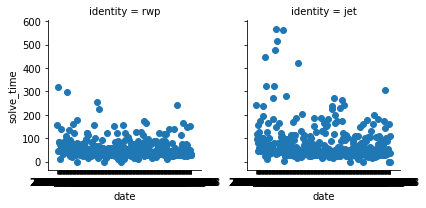

In [67]:
g = sns.FacetGrid(time_diffs, col='identity')
g = g.map(plt.scatter, 'date', 'solve_time')

In [70]:
time_diffs[['identity', 'solve_time']].groupby('identity').agg(['mean','min', 'max'])

solve_time            
               mean  min    max
identity                       
jet       79.260274  0.0  568.0
rwp       56.972603  0.0  320.0

Ummm...a 23 second differential in means? Really? That does NOT bode well for my chances. Notice that the min solve time for both of us is 0 (i.e. days on which either she or I failed to complete the puzzle (shame shame). Let's remove those essentially null points and also force max solves to align at 320 seconds. (It seems unfair to leave in all of my extraordinarily high outliers that came on early in the time period). Chalk those up to me being new to the NYT subscription and don't you dare accuse me of biasing my data. I would never!!

In [227]:
merge2 = merge.query('jet < 320 and jet > 1 and rwp > 1')
time_diffs = pd.melt(merge2, id_vars=['date'], 
                value_vars=['rwp', 'jet'],
                var_name = 'identity',
                value_name = 'solve_time'
            )
time_diffs.head()

,date,identity,solve_time
0,2018/08/08,rwp,157.0
1,2018/08/09,rwp,320.0
2,2018/08/10,rwp,44.0
3,2018/08/11,rwp,83.0
4,2018/08/12,rwp,44.0


In [228]:
time_diffs.shape

(696, 3)

We lost 34 data points post cleanse and the new mean difference is a whopping 17 seconds.

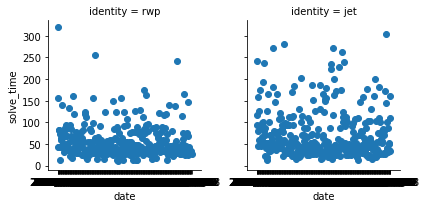

In [229]:
g = sns.FacetGrid(time_diffs, col='identity')
g = g.map(plt.scatter, 'date', 'solve_time')

In [230]:
time_diffs[['identity', 'solve_time']].groupby('identity').agg(['mean','min', 'count','max'])

solve_time                   
               mean   min count    max
identity                              
jet       72.350575  12.0   348  304.0
rwp       55.471264  11.0   348  320.0

This "best guess" after a year of data collection estimates rwp is a cool 17 seconds faster than jet. How confident are we in that guess? Do we need _more_ data to be certain? Can we build a confidence interval around that guess? Can we quantify how much certainty we have in that confidence interval?

## The Glorious Bootstrapped Confidence Interval

What if we assume that our sample of 348 data points is representative of rose and my solving ability. At this point in time I've already pulled all the data I can muster ( I only activated my subscripton around August 2018). If we sample from our sample, we can generate new guesses that will be slightly different from our original guess. This might seem like a logical jump, and it is, but what other option do we have? Instead of collecting more data by waiting for another year to roll by, we can sample from our prior year, assuming other samples would belong to the same underlying distribution of our sample, and take the resample we collect to be a renewed sample. By repeating this process many times, we'll generate a confidence interval to quanitify the true difference between her and my solve times. Let's get to work!

In [231]:
boot = resample(time_diffs.date, replace = True, n_samples = 348, random_state = 1)
boot = pd.DataFrame(boot)
boot = boot.rename(columns={0: "date"})

In [232]:
resamp = pd.merge(boot, time_diffs, on = 'date')

In [233]:
boot.date.nunique()

226

In [234]:
boot.shape

(348, 1)

Here we take a sample of the dates from (boot) with just as many sample points as our original sample. We can see that it only contains 226 unique dates compared to 348 in our original sample. (It can be shown [mathematically](https://stats.stackexchange.com/questions/88980/why-on-average-does-each-bootstrap-sample-contain-roughly-two-thirds-of-observat/88993) that each bootstrapped sample will contain roughly 2/3 of the original observations. Why do we sample the dates? It's important to keep the puzzle difficulty constant, if we sampled only times, then we could end up sampling my times on easy days and rose's times on hard days (thinking Saturday difficulty vs Monday). By sampling dates, we control for difficulty and are comparing fairly.

In [235]:
time_diffs.date.nunique()

348

In [236]:
resamp.date.nunique()

226

In [237]:
resamp.head()

,date,identity,solve_time
0,2018/09/16,rwp,18.0
1,2018/09/16,jet,37.0
2,2018/09/16,rwp,18.0
3,2018/09/16,jet,37.0
4,2019/04/13,rwp,97.0


In [238]:
resamp[['identity', 'solve_time']].groupby('identity').agg(['mean','min', 'count','max'])

solve_time                   
               mean   min count    max
identity                              
jet       70.379310  12.0   348  281.0
rwp       55.252874  11.0   348  320.0

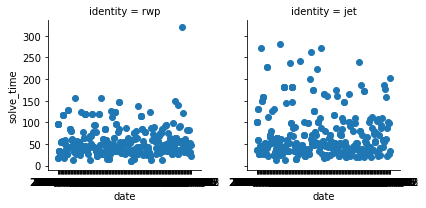

In [239]:
g = sns.FacetGrid(resamp, col='identity')
g = g.map(plt.scatter, 'date', 'solve_time')

According to this reampled data I'm still 15 seconds slower than rwp. You can see that the resampled data follows more or less a similar distribution to the original data. The next step is simply to repeat this resampling process, keep track of our mean differences, and examine the _distribution of differences_ at the end to obtain our final, highly anticipated, confidence interval.

In [240]:
def get_bootstrap_samples(times, size):

    diff_means = []
    for i in range(0,size):
        boot = resample(times.date, replace = True, n_samples = 348)
        boot = pd.DataFrame(boot)
        boot = boot.rename(columns={0: "date"})
        resamp = pd.merge(boot, times, on = 'date')
        j = resamp[resamp['identity'] == 'jet']
        rwp = resamp[resamp['identity'] == 'rwp']
        diff_mean = j.solve_time.mean() - rwp.solve_time.mean()
        diff_means.append(diff_mean)

    return diff_means

In [241]:
small_samp = get_bootstrap_samples(time_diffs, 10)
small_samp

[18.643678160919542,
 18.692528735632187,
 16.939655172413786,
 14.856321839080465,
 18.798850574712638,
 17.968390804597703,
 18.913793103448285,
 17.908045977011497,
 18.922413793103445,
 14.715517241379317]

In [242]:
mean(small_samp)

17.635919540229885

(array([  9.,  29.,  88., 159., 251., 226., 142.,  67.,  24.,   5.]),
 array([ 8.4454023 , 10.15574713, 11.86609195, 13.57643678, 15.28678161,
        16.99712644, 18.70747126, 20.41781609, 22.12816092, 23.83850575,
        25.54885057]),
 <a list of 10 Patch objects>)

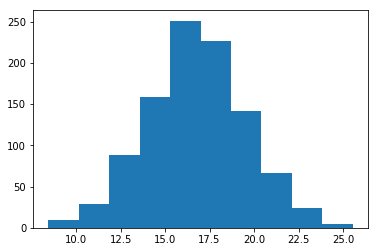

In [243]:
med_samp = get_bootstrap_samples(time_diffs, 1000)
plt.hist(med_samp)

In [244]:
np.percentile(med_samp, 97.5)

22.394109195402297

In [245]:
np.percentile(med_samp, 2.5)

11.404166666666667

Based on these results, we can say with 95% confidence that she's between 11 and 22 seconds faster than me

## Cheating

Rose is still not convinced. The data is far more spread out at the extremes for me than it is for her. She thinks this is more indicative of the fact that I have a tendancy to "give up" when I can't smoothly solve a puzzle, and I let the clock tick onwards without care to the disastrous effects such a habit has on future analyses. She says if we slim the data down to a reasonable solve time for an average puzzle, say just over a minute, then the difference won't be so extreme. Let's test this hypothesis.

Restrict solve times to under 72 seconds.

In [246]:
merge2 = merge.query('jet < 72 and jet > 1 and rwp > 1 and rwp < 72')
time_diffs = pd.melt(merge2, id_vars=['date'], 
                value_vars=['rwp', 'jet'],
                var_name = 'identity',
                value_name = 'solve_time'
            )
time_diffs.head()

,date,identity,solve_time
0,2018/08/12,rwp,44.0
1,2018/08/17,rwp,60.0
2,2018/08/20,rwp,42.0
3,2018/08/21,rwp,66.0
4,2018/08/23,rwp,44.0


In [247]:
time_diffs.shape

(414, 3)

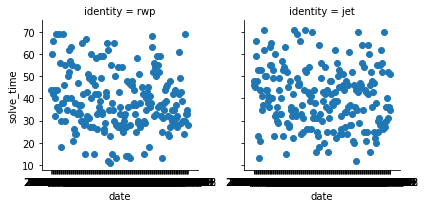

In [248]:
g = sns.FacetGrid(time_diffs, col='identity')
g = g.map(plt.scatter, 'date', 'solve_time')

Now the plots are almost entirely indistinguishable from each other, we've removed the high variance at the extreme solve times and now the mean difference in our sample is under 2 seconds. Surely upon resampling hundreds of times we'll select some samples of dates where I am on average faster and the distribution will show us. Let's take a look!

In [249]:
time_diffs[['identity', 'solve_time']].groupby('identity').agg(['mean','min', 'count','max'])

solve_time                  
               mean   min count   max
identity                             
jet       40.594203  12.0   207  71.0
rwp       38.657005  11.0   207  69.0

(array([  1.,  10.,  44., 105., 211., 256., 193., 128.,  46.,   6.]),
 array([-1.21264368, -0.62413793, -0.03563218,  0.55287356,  1.14137931,
         1.72988506,  2.3183908 ,  2.90689655,  3.4954023 ,  4.08390805,
         4.67241379]),
 <a list of 10 Patch objects>)

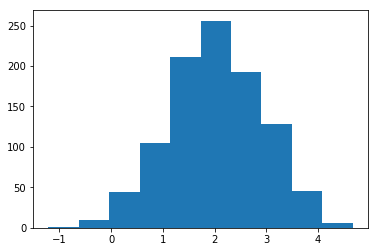

In [250]:
med_samp = get_bootstrap_samples(time_diffs, 1000)
plt.hist(med_samp)

In [251]:
np.percentile(med_samp, 2.5)

0.2126436781609229

So....we're still 95% confident she's faster? Guess I better quit the code for a while and read some books, my wordplay skills are clearly lacking...